In [1]:
# 测试
# 1.获取测试视频文件地址和标签
# 2.预处理视频
# 3.送入模型推理
# 4.得到对应类别概率

In [2]:
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

2022-09-22 17:44:15.567085: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
# 读取测试文件

In [4]:
test_df = pd.read_csv("test.csv")

In [5]:
test_df.sample(5)

,video_name,tag
1435,v_PlayingGuitar_g03_c01.avi,PlayingGuitar
1371,v_PlayingDhol_g07_c02.avi,PlayingDhol
411,v_Bowling_g02_c01.avi,Bowling
592,v_CliffDiving_g05_c05.avi,CliffDiving
1507,v_PlayingSitar_g07_c03.avi,PlayingSitar


In [6]:
# 序列长度（视频采样帧数）
MAX_SEQ_LENGTH = 20
# CNN提取特征向量大小
NUM_FEATURES = 1536
# 裁剪图片大小
IMG_SIZE = 299


In [7]:
# 裁剪正中间的正方形
def crop_center_square(img):
    # 获取长度和宽度
    h,w =  img.shape[:2]
    # 判断短边，作为正方形的边
    square_w = min(h,w)
    
    start_x = w//2 - square_w//2
    end_x = start_x + square_w
    
    start_y = h//2 - square_w//2
    end_y = start_y + square_w
    
    result = img[start_y:end_y,start_x:end_x]
    
    return result

# 加载视频
def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)



# 特征提取器
def build_feature_extractor():
    
    feature_extractor = keras.applications.inception_resnet_v2.InceptionResNetV2(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_resnet_v2.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


In [8]:
# 加载特征提取器
feature_extractor = build_feature_extractor()

2022-09-22 17:44:17.199140: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-09-22 17:44:17.236844: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:d1:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-09-22 17:44:17.236872: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-09-22 17:44:17.240031: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-09-22 17:44:17.240105: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-09-22 17:44:17.241082: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcu

In [9]:
# 提取视频特征
def getVideoFeat(frames):
    
    frames_count = len(frames)

    # 如果视频帧数太短，则需要补白
    if frames_count < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - frames_count
        # 补全0图片数组
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))

        frames = np.concatenate((frames, padding))

    # 取前MAX_SEQ_LENGTH帧
    frames = frames[:MAX_SEQ_LENGTH,:]


    # 批量计算视频特征 N,1024
    video_feat = feature_extractor.predict(frames)

    return video_feat

In [10]:
# 所有列别
train_df = pd.read_csv("train.csv")
class_vocab = pd.unique(train_df["tag"]).tolist()

In [11]:
# 定义模型
def video_cls_model(class_vocab):
    # 类别数量
    classes_num = len(class_vocab)

    model = keras.Sequential([
        layers.Input(shape=(MAX_SEQ_LENGTH, NUM_FEATURES)),
        # input: (N,20,1024), output: (N,32)
        layers.GRU(64, return_sequences=False),
        # output: (N,classes_num)
        layers.Dense(classes_num, activation="softmax")
    ])
    # 编译模型
    model.compile(
        optimizer=optimizers.Adam(0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [12]:
model = video_cls_model(class_vocab)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 64)                307584    
_________________________________________________________________
dense (Dense)                (None, 50)                3250      
Total params: 310,834
Trainable params: 310,834
Non-trainable params: 0
_________________________________________________________________


In [14]:
# 恢复权重
filepath = "./saved_model/rnn/video_classifier_rnn"
model.load_weights(filepath)

In [15]:
import random
import IPython
from IPython.display import Image

In [16]:
label_chinese = {'ApplyEyeMakeup':'涂眼妆',
                'Archery':'射箭',
                'BabyCrawling':'婴儿爬行',
                'BandMarching':'乐队行进',
                'BaseballPitch':'棒球投掷',
                'Basketball':'篮球',
                'BasketballDunk':'扣篮',
                'BenchPress':'仰卧推举',
                'Biking':'骑行',
                'Billiards':'台球',
                'Bowling':'保龄球',
                'BoxingPunchingBag':'拳击拳击袋',
                'BoxingSpeedBag':'拳击速度球',
                'BrushingTeeth':'刷牙',
                'CliffDiving':'悬崖跳水',
                'CricketBowling':'板球保龄球',
                'CricketShot':'板球射击',
                'Diving':'跳水',
                'Drumming':'击鼓',
                'FrontCrawl':'自由泳',
                'GolfSwing':'高尔夫挥杆',
                'Haircut':'理发',
                'Hammering':'锤击',
                'HammerThrow':'锤子投掷',
                'HandstandPushups':'倒立俯卧撑',
                'HeadMassage':'头部按摩',
                'HorseRiding':'骑马',
                'IceDancing':'冰舞',
                'JumpRope':'跳绳',
                'Kayaking':'皮划艇',
                'Nunchucks':'双节棍',
                'PlayingCello':'演奏大提琴',
                'PlayingDaf':'演奏达夫鼓',
                'PlayingDhol':'演奏多尔鼓',
                'PlayingFlute':'吹长笛',
                'PlayingGuitar':'弹吉他',
                'PlayingSitar':'弹奏西塔琴',
                'PoleVault':'撑竿跳高',
                'Punch':'拳击',
                'RockClimbingIndoor':'室内攀岩',
                'Rowing':'划船',
                'ShavingBeard':'剃须',
                'Shotput':'铅球',
                'Skiing':'滑雪',
                'SoccerJuggling':'颠球',
                'SoccerPenalty':'足球点球',
                'TableTennisShot':'乒乓球',
                'TennisSwing':'网球挥杆',
                'WallPushups':'墙俯卧撑',
                'WritingOnBoard':'板上书写'
}

In [17]:
len(label_chinese)

50

In [18]:
# 所有测试文件
filelist = test_df['video_name'].values.tolist()

In [19]:
def testVideo():
    # 随机挑选
    test_file = random.sample(filelist,1)[0]
    
    gd_label = test_file.split('_')[1]
    print('文件名:{}'.format(test_file) )
    print('真实类别:{}\n'.format(label_chinese[gd_label]) )
    
    # 读取视频每一帧
    frames = load_video(os.path.join('test', test_file))
    # 挑选前20帧显示
    frames = frames[:20].astype(np.uint8)
    # 保存为GIF
    imageio.mimsave("animation.gif", frames, fps=10)

    
    # 获取特征
    feat = getVideoFeat(frames)
    # 推理
    probabilities = model.predict(feat[None,:])[0]
    
    print('预测的前10个类别：\n')
    # 索引从大到小正确的排序
    for i in np.argsort(probabilities)[::-1][:10]:
        label = class_vocab[i]
        label_zh = label_chinese[label]
        p = probabilities[i]
        print('{} ({}): {}%'.format(label_zh,label,round(p*100,2)))
    
    print('\n')
    
    return Image(filename='animation.gif',embed=True)

文件名:v_PlayingFlute_g07_c06.avi
真实类别:吹长笛



2022-09-22 17:44:26.069794: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-22 17:44:26.074338: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2600000000 Hz
2022-09-22 17:44:28.695629: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-09-22 17:44:29.429495: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2022-09-22 17:44:30.360312: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-09-22 17:44:31.007847: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


预测的前10个类别：

吹长笛 (PlayingFlute): 98.37%
骑马 (HorseRiding): 0.31%
自由泳 (FrontCrawl): 0.2%
跳水 (Diving): 0.09%
刷牙 (BrushingTeeth): 0.09%
倒立俯卧撑 (HandstandPushups): 0.06%
墙俯卧撑 (WallPushups): 0.06%
射箭 (Archery): 0.06%
弹奏西塔琴 (PlayingSitar): 0.05%
击鼓 (Drumming): 0.05%




2022-09-22 17:44:32.055829: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


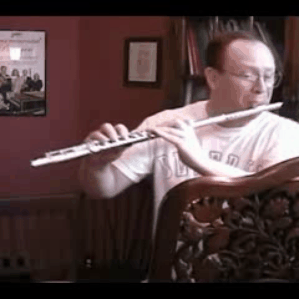

In [20]:
testVideo()

文件名:v_PoleVault_g03_c03.avi
真实类别:撑竿跳高

预测的前10个类别：

撑竿跳高 (PoleVault): 46.45%
篮球 (Basketball): 12.25%
颠球 (SoccerJuggling): 10.44%
双节棍 (Nunchucks): 3.67%
铅球 (Shotput): 2.96%
射箭 (Archery): 2.9%
高尔夫挥杆 (GolfSwing): 2.44%
锤击 (Hammering): 2.06%
扣篮 (BasketballDunk): 1.55%
骑马 (HorseRiding): 1.39%




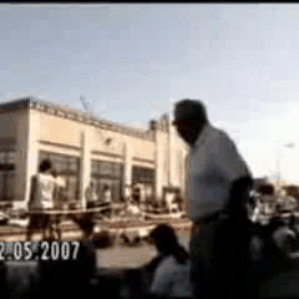

In [21]:
testVideo()

文件名:v_Kayaking_g01_c02.avi
真实类别:皮划艇

预测的前10个类别：

皮划艇 (Kayaking): 88.8%
划船 (Rowing): 6.37%
演奏多尔鼓 (PlayingDhol): 0.7%
悬崖跳水 (CliffDiving): 0.57%
头部按摩 (HeadMassage): 0.45%
演奏大提琴 (PlayingCello): 0.42%
射箭 (Archery): 0.29%
自由泳 (FrontCrawl): 0.25%
击鼓 (Drumming): 0.21%
演奏达夫鼓 (PlayingDaf): 0.19%




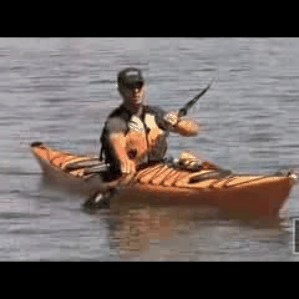

In [23]:
testVideo()